# Anime Recomendation System 


![](https://1.bp.blogspot.com/-JiroTj4WfJE/XyARMYs1WwI/AAAAAAAAAgw/g5rf_SM5vNExdLKtAXsvRIlGF-j4NdsNACLcBGAsYHQ/w625-h400/Presentation2.png)

## Content-Based Filtering

### Data Loading

**imports**

we've got some basic system imports, 🐼 and num🐍, 📊lib and fancy `SimpleNamespace` for using dictionaries cuz `'"[]` are annoying

In [ ]:
import os,re,zipfile
import pandas as pd
import numpy as np
from types import SimpleNamespace
from matplotlib import pyplot as plt
import itertools
plt.style.use('seaborn')
base_size = 10
sizes = SimpleNamespace(**dict(small=(1*base_size,1*base_size),medium=(2*base_size,2*base_size),large=(3*base_size,3*base_size)))

**Downlaod the data**

In [2]:
%%time
zip_name = 'anime-recommendations-database.zip'
if not os.path.exists(zip_name):
  os.environ['KAGGLE_USERNAME'] = "" # username from the json file
  os.environ['KAGGLE_KEY'] = "" # key from the json file
  !kaggle datasets download CooperUnion/anime-recommendations-database

100% 25.0M/25.0M [00:00<00:00, 38.8MB/s]
100% 25.0M/25.0M [00:00<00:00, 83.3MB/s]
CPU times: user 24.8 ms, sys: 4.82 ms, total: 29.6 ms
Wall time: 2.41 s


**Unzip the data**

In [ ]:
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(zip_name.split('.')[0])

Let's find the files

In [ ]:
os.listdir(zip_name.split('.')[0])

['anime.csv', 'rating.csv']

Have a look throught the dataset
![](http://assets.stickpng.com/images/58582c01f034562c582205ff.png)

In [4]:
anime = pd.read_csv(zip_name.split('.')[0] + '/anime.csv')
anime.genre = anime.genre.fillna('None')
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


### Data Aggregation

Let's get a list of unique `genre`

In [ ]:
unique_genres = list(set([x.strip() for x in list(itertools.chain(*anime.genre.fillna('None').str.split(',')))]))
for gen in unique_genres:
  anime[gen] = 0

For each row we create something similar with the output of `pd.get_dummies` where we check the found genres against all the unique ones resulting into an array of `1` and `0` where given `genres` vs `unique_genres`

In [ ]:
def binary_match(x,y):
  x = [t.strip() for t in x]
  y = [t.strip() for t in y]
  matches = dict(zip(y,np.zeros(len(y))))
  for j in y:
    if j in x:
      matches[j] = 1
    else:
      matches[j] = 0
  return matches

In [ ]:
test = anime.genre.apply(lambda x: binary_match(x.split(','),unique_genres))

In [ ]:
binary_df = pd.DataFrame(test.values.tolist())

In [ ]:
anime[unique_genres] = binary_df[unique_genres]

In [ ]:
anime

,anime_id,name,genre,type,episodes,rating,members,Military,Harem,Shoujo Ai,Hentai,Action,Space,Ecchi,Magic,Josei,Yaoi,Cars,Shounen Ai,Police,Kids,Seinen,Psychological,Drama,Music,Shoujo,School,None,Fantasy,Shounen,Vampire,Sci-Fi,Super Power,Horror,Demons,Sports,Supernatural,Slice of Life,Parody,Dementia,Romance,Yuri,Game,Adventure,Historical,Samurai,Thriller,Martial Arts,Comedy,Mecha,Mystery
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12290,5543,Under World,Hentai,OVA,1,4.28,183,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


***Looks good, right ?***

 
![](http://3.bp.blogspot.com/-U6YNKM54nGw/Vptgy7Qi9lI/AAAAAAAAGao/-qlVB60Go3o/s1600/OPM-ep-11b.jpg)

### KMeans Clustering for groups

In [ ]:
from sklearn.cluster import KMeans

We use the number of unique genres as the number of clusters for a fast testing

In [ ]:
kmeans = KMeans(n_clusters=len(unique_genres), random_state=0).fit(anime[unique_genres])
anime['clusters'] = kmeans.labels_

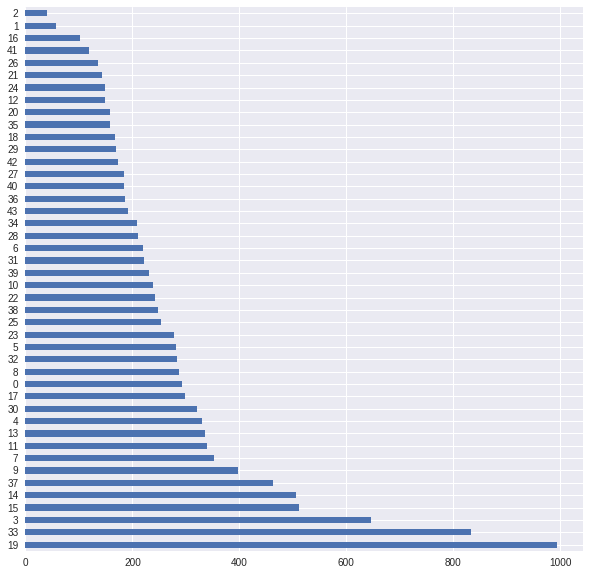

In [ ]:
anime.clusters.value_counts().plot.barh(figsize=(10,10))

Then we define a searching by term function getting all the animes from that cluster sorted by `rating`

In [ ]:
def awesome_find(df,search_term):
  tmpdf = df.copy()
  for x in search_term.split():
    tmpdf = tmpdf[tmpdf.name.str.upper().str.contains(x.strip().upper())]
  return df[df.clusters == tmpdf.sort_values(by='rating',ascending=False)[:1].clusters.values[0]][['anime_id','name','genre','type','episodes','members']]

![](https://static.zerochan.net/Akame.%28Akame.ga.Kill%21%29.full.1742516.jpg)

In [ ]:
awesome_find(anime,'Akame ga Kill')

,anime_id,name,genre,type,episodes,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,793665
24,164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,339556
101,18115,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy, Magic, Shounen",TV,25,245026
121,486,Kino no Tabi: The Beautiful World,"Action, Adventure, Slice of Life",TV,13,102822
133,2685,Tsubasa: Tokyo Revelations,"Action, Adventure, Drama, Fantasy, Romance, Sh...",OVA,3,57963
...,...,...,...,...,...,...
11076,30736,Shingeki no Bahamut: Virgin Soul,"Action, Adventure, Demons, Fantasy, Magic, Sup...",TV,24,20953
11085,34086,Tales of Zestiria the X (2017),"Action, Adventure, Fantasy",TV,12,10848
11644,1331,Dragon Pink,"Action, Adventure, Comedy, Fantasy, Hentai, Ma...",OVA,3,3467
11871,2185,Words Worth Gaiden,"Action, Adventure, Fantasy, Hentai",OVA,2,2402


In [ ]:
from wordcloud import WordCloud

In [ ]:
def create_wc(list_of_lists):
  words = list()
  for x in list_of_lists:
    for y in x.split(','):
      words.append(y.strip())
      
  # Create and generate a word cloud image:
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(words))
  return wordcloud
  

In [ ]:
def plot_figures(figures, nrows = 1, ncols=1):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=(20,20))
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(f'Most Freqent words for the group {title+1}')
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [ ]:
clouds = dict()
for x in anime.clusters.unique():
  clouds[x] = create_wc(anime[anime.clusters == x].genre.values.tolist())

***Let's see our clusters***
![](https://pbs.twimg.com/media/D_3qlpkVAAE5Rig?format=jpg&name=large)

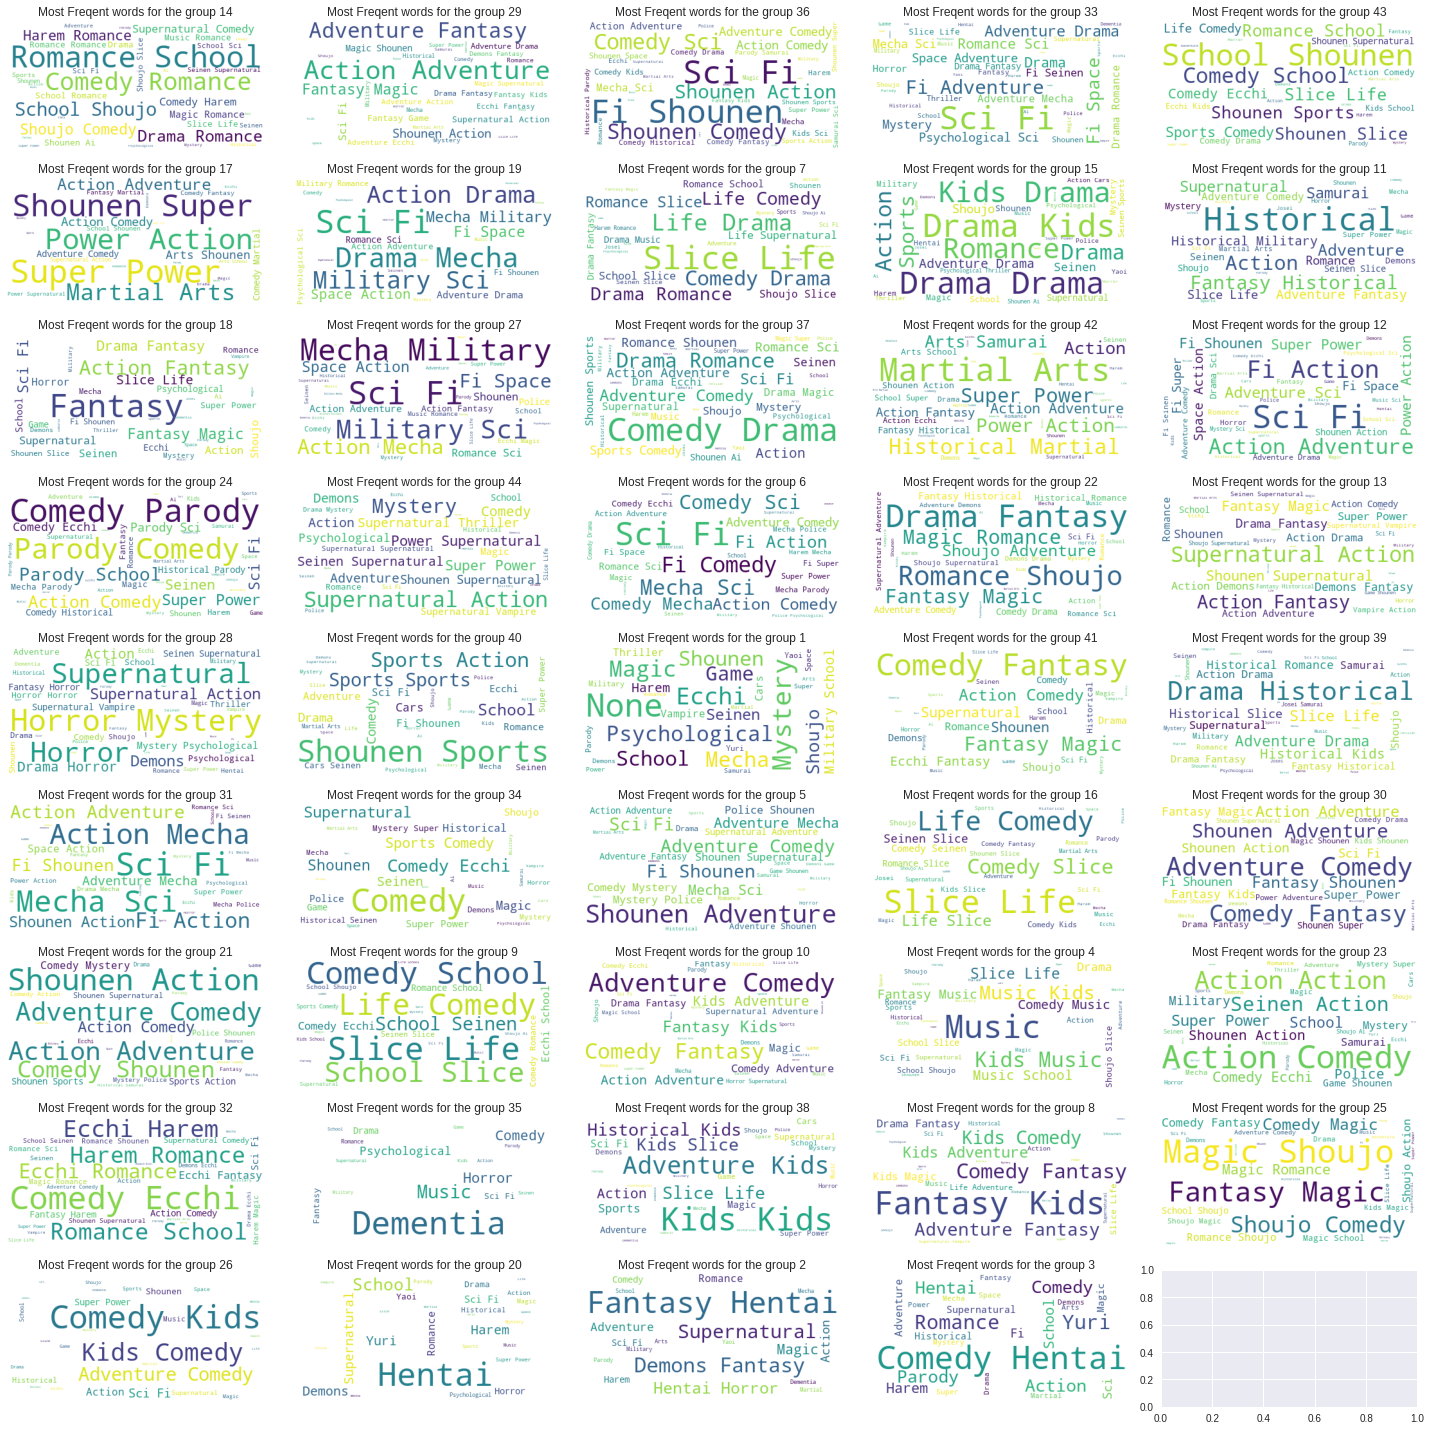

In [ ]:
plot_figures(clouds,9,5)

### Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

Our function computes the cosine similarity between the `genre_vector` of the given search term against all of the others

In [ ]:
def search_cosine(df,search):
  tmpdf = df.copy()
  search_term = tmpdf[tmpdf.name == search][unique_genres].values
  tmpdf['similarity'] = cosine_similarity(search_term,tmpdf[unique_genres].values)[0].tolist()

  return tmpdf.sort_values(by='similarity',ascending=False)[['anime_id','name','genre','type','episodes','members','similarity']]

The only do `downgrade` on this approach is that the search has to be an exact match, however this can be solved through an `elasticsearch` index

![](https://wallpapercave.com/wp/wp3155076.jpg)

In [ ]:
src = search_cosine(anime,'Sword Art Online')
src

,anime_id,name,genre,type,episodes,members,similarity
2132,21881,Sword Art Online II,"Action, Adventure, Fantasy, Game, Romance",TV,24,537892,1.000000
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,893100,1.000000
3392,20021,Sword Art Online: Extra Edition,"Action, Adventure, Fantasy, Game, Romance",Special,1,121722,1.000000
10908,31765,Sword Art Online Movie: Ordinal Scale,"Action, Adventure, Fantasy, Game, Romance",Movie,1,50944,1.000000
5078,27891,Sword Art Online II: Debriefing,"Action, Adventure, Fantasy, Game",Special,1,39092,0.894427
...,...,...,...,...,...,...,...
7737,29944,Kuchao,Dementia,Movie,1,184,0.000000
7736,21335,Double Circle,"Sci-Fi, Super Power",ONA,6,4249,0.000000
7735,32765,Cherry Blossom (Music),Music,Music,1,113,0.000000
2255,10232,Tamayura: Hitotose,"Comedy, Drama, Slice of Life",TV,12,25760,0.000000


## Collaborative Filtering

![](https://steamuserimages-a.akamaihd.net/ugc/967599421482269794/9CA0E9C578D6A496350708B0E2F5DF59ECAE4439/)

In [5]:
rating = pd.read_csv(zip_name.split('.')[0]+'/rating.csv')
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [ ]:
mrating = rating.merge(rating.groupby('user_id').agg({'rating':'mean'}).reset_index(),on='user_id')
mrating = mrating.drop(mrating[mrating.rating_x < mrating.rating_y].index)
mrating

,user_id,anime_id,rating_x,rating_y
47,1,8074,10,-0.712418
81,1,11617,10,-0.712418
83,1,11757,10,-0.712418
101,1,15451,10,-0.712418
153,2,11771,10,2.666667
...,...,...,...,...
7813730,73515,13659,8,7.719388
7813733,73515,17187,9,7.719388
7813734,73515,22145,10,7.719388
7813735,73516,790,9,9.000000


## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_comps = 3

In [ ]:
comp = pd.DataFrame(PCA(n_components=n_comps).fit_transform(mrating[['user_id','anime_id','rating_x']]),columns=[f'comp_{x}'for x in range(1,4)])
comp['anime_id'] = mrating['anime_id']
comp = comp.merge(anime[['anime_id','name']],right_on='anime_id',left_on='anime_id',how='inner')
comp

,comp_1,comp_2,comp_3,anime_id,name
0,36979.379560,19271.801823,-1.435758,8074.0,Highschool of the Dead
1,36864.979321,12890.819470,8.604092,8074.0,Highschool of the Dead
2,36501.255218,-8729.123562,-2.260925,8074.0,Highschool of the Dead
3,36504.981554,-7890.072244,-2.266146,8074.0,Highschool of the Dead
4,36575.509130,-2723.534636,-2.298376,8074.0,Highschool of the Dead
...,...,...,...,...,...
2330380,-36744.486077,-7441.741918,0.851111,17147.0,Gakkatsu! 2nd Season
2330381,-36660.120947,648.960605,-1.199318,25087.0,Ie Naki Ko Remi Specials (2001)
2330382,-36641.406527,1792.807522,-1.206458,29757.0,Mori no e
2330383,-36896.998157,-8205.349210,-2.143892,7616.0,Michi


In [ ]:
comp_grp = comp.groupby('name').mean().reset_index()
comp_grp.name = comp_grp.name.str.replace('&quot;',"`")
comp_grp

,name,comp_1,comp_2,comp_3,anime_id
0,`0`,-11120.206150,-5219.625973,-0.704695,20707.0
1,`Bungaku Shoujo` Kyou no Oyatsu: Hatsukoi,1635.899945,-518.535030,0.007314,7669.0
2,`Bungaku Shoujo` Memoire,-1095.114790,-231.043774,0.065327,8481.0
3,`Bungaku Shoujo` Movie,-1846.898975,40.053205,-0.135169,6408.0
4,`Eiji`,-7032.249068,261.233554,1.754537,6076.0
...,...,...,...,...,...
8488,xxxHOLiC,1419.997992,93.118756,-0.038304,861.0
8489,xxxHOLiC Kei,2172.334257,179.512393,-0.058045,3091.0
8490,xxxHOLiC Movie: Manatsu no Yoru no Yume,3869.821060,436.500647,0.132941,793.0
8491,xxxHOLiC Rou,-1700.534327,738.029495,-0.003196,6864.0


In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(comp_grp, x='comp_1', y='comp_2', z='comp_3',color='name',size_max=7, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.write_html('pca.html')

## ELK Stack Recommendation System

In [ ]:
anime['genre_list'] = anime.genre.str.split(',').apply(lambda x: [y.strip() for y in x])

In [40]:
anime[:3]

,anime_id,name,genre,type,episodes,rating,members,genre_list
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"[Action, Comedy, Historical, Parody, Samurai, ..."


In [8]:
rating[:3]

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1


In [ ]:
try:
  import elasticsearch
except:
  !pip install elasticsearch
  import elasticsearch

In [ ]:
from elasticsearch.helpers import bulk

In [ ]:
import requests as req

In [ ]:
es_host = ''
es_port = ''                                    
es_user = ''
es_pass = ''

In [22]:
print(req.get(f'{es_host}:{es_port}/_cat/indices',auth=(es_user, es_pass)).text)

green open apm-7.7.0-onboarding-2020.06.01 8AuzajpiSha3LKUIS1-0DA 1 1     1 0    14kb    7kb
green open apm-7.7.0-error-000001          g0mvvPSNRBqvTKT3XkxEtA 1 1     0 0    416b   208b
green open .apm-agent-configuration        NuHbtEHjReCuzcGzkUkTvQ 1 1     0 0    416b   208b
green open apm-7.7.0-transaction-000001    okf6EQuSRBWP_uPze2r0_g 1 1     0 0    416b   208b
green open .kibana_1                       9pXwv0ngRtaJYCuSSEmeRg 1 1   660 3   2.4mb  1.2mb
green open kibana_sample_data_flights      _JNZbj9KQnOL4cD8CIhfEw 1 1 13059 0  12.6mb  6.3mb
green open apm-7.7.0-span-000001           N8UCNrmaRjiaX8NnjHnlzw 1 1     0 0    416b   208b
green open .security-7                     cyFn8axBRwOjJDq5JHUhhQ 1 1    47 2 179.1kb 89.5kb
green open .apm-custom-link                NM_Cj4S4RCCzFNKFyyrwCQ 1 1     0 0    416b   208b
green open kibana_sample_data_ecommerce    ioSMO_biTUa2cusEJqScnA 1 1  4675 0   9.7mb  4.8mb
green open .kibana_task_manager_1          VHh1p97rQDCas32Xmi5LRA 1 1 

In [ ]:
es = elasticsearch.Elasticsearch(
    [
        f'{es_host}:{es_port}'                          
    ], 
    http_auth=(es_user, es_pass),
  )

In [ ]:
print(es.indices.get('*'))

In [ ]:
def index_template(index,id,doc):
  return {
    '_index': index,
    '_id': id,
    '_source': doc
}

In [41]:
anime[:2]

,anime_id,name,genre,type,episodes,rating,members,genre_list
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."


In [42]:
anime.anime_id.nunique() / len(anime)

1.0

In [79]:
anime_actions = [
  index_template('anime',x.anime_id,{
      'anime_id': x.anime_id ,
      'name': x.name,
      'genres': x.genre_list,
      'type': x.type if str(x.type) != 'nan' else 'Unknown',
      'episodes': int(x.episodes) if x.episodes not in ['Unknown'] else 0,
      'rating': x.rating if str(x.rating) != 'nan' else 0

  })  for x in anime.itertuples()              
]
anime_actions[:2]

[{'_id': 32281,
  '_index': 'anime',
  '_source': {'anime_id': 32281,
   'episodes': 1,
   'genres': ['Drama', 'Romance', 'School', 'Supernatural'],
   'name': 'Kimi no Na wa.',
   'rating': 9.37,
   'type': 'Movie'}},
 {'_id': 5114,
  '_index': 'anime',
  '_source': {'anime_id': 5114,
   'episodes': 64,
   'genres': ['Action',
    'Adventure',
    'Drama',
    'Fantasy',
    'Magic',
    'Military',
    'Shounen'],
   'name': 'Fullmetal Alchemist: Brotherhood',
   'rating': 9.26,
   'type': 'TV'}}]

In [80]:
%%time
bulk(es,anime_actions)

CPU times: user 306 ms, sys: 13.1 ms, total: 319 ms
Wall time: 8.6 s


(12294, [])

In [ ]:
def positive(x):
  return 0 if x < 0 else x

In [74]:
frating = rating.groupby('user_id').agg({
    'anime_id': list,
    'rating': list
}).reset_index()
frating['mixed'] = frating[['anime_id','rating']].apply(lambda x: [ {'anime_id': i, 'rating': positive(r) if str(r) != 'nan' else 0} for i,r in zip(x.anime_id,x.rating)] ,axis=1)
frating

,user_id,anime_id,rating,mixed
0,1,"[20, 24, 79, 226, 241, 355, 356, 442, 487, 846...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[{'anime_id': 20, 'rating': 0}, {'anime_id': 2..."
1,2,"[11771, 12189, 16417]","[10, -1, -1]","[{'anime_id': 11771, 'rating': 10}, {'anime_id..."
2,3,"[20, 154, 170, 199, 225, 341, 430, 527, 552, 8...","[8, 6, 9, 10, 9, 6, 7, 7, 7, 10, 7, 7, 7, 8, 6...","[{'anime_id': 20, 'rating': 8}, {'anime_id': 1..."
3,4,"[6, 72, 121, 150, 166, 205, 226, 857, 1292, 14...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[{'anime_id': 6, 'rating': 0}, {'anime_id': 72..."
4,5,"[6, 15, 17, 18, 20, 22, 24, 30, 45, 47, 57, 63...","[8, 6, 6, 6, 6, 5, 1, 1, 7, 8, 7, 1, 6, 6, 6, ...","[{'anime_id': 6, 'rating': 8}, {'anime_id': 15..."
...,...,...,...,...
73510,73512,"[60, 98, 101, 120, 199, 226, 339, 355, 552, 65...","[10, 8, 10, 5, 10, 9, 10, -1, 7, 8, 8, 10, 8]","[{'anime_id': 60, 'rating': 10}, {'anime_id': ..."
73511,73513,"[1, 5, 71, 101, 164, 180, 181, 195, 196, 199, ...","[9, 8, 6, 8, 8, 5, 5, 7, 7, 9, 8, 8, 7, 10, 8,...","[{'anime_id': 1, 'rating': 9}, {'anime_id': 5,..."
73512,73514,[512],[10],"[{'anime_id': 512, 'rating': 10}]"
73513,73515,"[1, 5, 6, 19, 27, 30, 33, 57, 67, 71, 72, 73, ...","[10, 10, 10, 9, 9, 8, 10, 8, 8, 9, 10, 9, 10, ...","[{'anime_id': 1, 'rating': 10}, {'anime_id': 5..."


In [77]:
user_actions = [
  index_template('anime-users',x.user_id,{
    'user_id': x.user_id,
    'rated': x.mixed
  })  for x in frating.itertuples()              
]
user_actions[:2]

[{'_id': 1,
  '_index': 'anime-users',
  '_source': {'rated': [{'anime_id': 20, 'rating': 0},
    {'anime_id': 24, 'rating': 0},
    {'anime_id': 79, 'rating': 0},
    {'anime_id': 226, 'rating': 0},
    {'anime_id': 241, 'rating': 0},
    {'anime_id': 355, 'rating': 0},
    {'anime_id': 356, 'rating': 0},
    {'anime_id': 442, 'rating': 0},
    {'anime_id': 487, 'rating': 0},
    {'anime_id': 846, 'rating': 0},
    {'anime_id': 936, 'rating': 0},
    {'anime_id': 1546, 'rating': 0},
    {'anime_id': 1692, 'rating': 0},
    {'anime_id': 1836, 'rating': 0},
    {'anime_id': 2001, 'rating': 0},
    {'anime_id': 2025, 'rating': 0},
    {'anime_id': 2144, 'rating': 0},
    {'anime_id': 2787, 'rating': 0},
    {'anime_id': 2993, 'rating': 0},
    {'anime_id': 3455, 'rating': 0},
    {'anime_id': 4063, 'rating': 0},
    {'anime_id': 4214, 'rating': 0},
    {'anime_id': 4224, 'rating': 0},
    {'anime_id': 4581, 'rating': 0},
    {'anime_id': 4744, 'rating': 0},
    {'anime_id': 4898, 'rating

In [78]:
%%time
bulk(es,user_actions)

CPU times: user 8.01 s, sys: 166 ms, total: 8.18 s
Wall time: 1min 41s


(73515, [])